In [1]:
#Reference: https://github.com/dennybritz/nn-from-scratch/blob/master/nn-from-scratch.ipynb

import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib
# Display plots inline and change default figure size
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)

/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


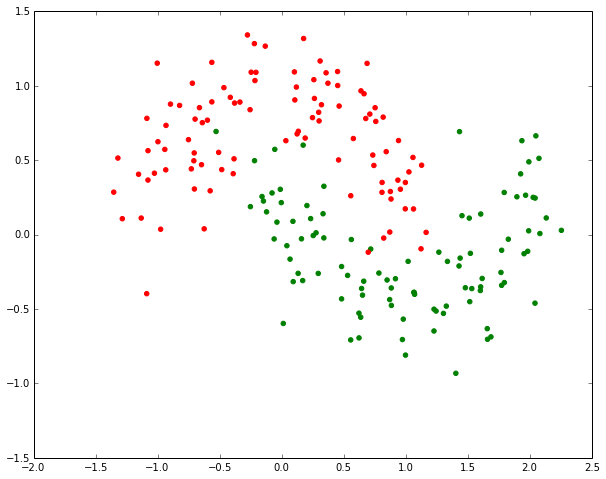

In [2]:
# Generate a dataset and plot it
np.random.seed(0)
X, y = sklearn.datasets.make_moons(200, noise=0.20)
color0 = ['red' if l == 0 else 'green' for l in y]
plt.scatter(X[:,0], X[:,1], color=color0)

In [3]:
# ipdb.set_trace()
num_examples = len(X) # training set size
nn_input_dim = 2 # input layer dimensionality
nn_output_dim = 2 # output layer dimensionality
 
# Gradient descent parameters (I picked these by hand)
epsilon = 0.01 # learning rate for gradient descent
reg_lambda = 0.01 # regularization strength

In [4]:
# Helper function to evaluate the total loss on the dataset
def calculate_loss(model):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # Forward propagation to calculate our predictions
    z1 = X.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    probs_new = probs[range(num_examples), y]

    corect_logprobs = -np.log(probs[range(num_examples), y])

    data_loss = np.sum(corect_logprobs)

    data_loss += reg_lambda/2 * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
    return 1./num_examples * data_loss

In [5]:
# Helper function to predict an output (0 or 1)
def predict(model, x):
    model_rel = {}
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # Forward propagation
    z1 = x.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    model_rel = {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2, 'z1':z1, 'a1': a1, 'z2': z2}
    return probs, model_rel

In [6]:
# This function learns parameters for the neural network and returns the model.
# - nn_hdim: Number of nodes in the hidden layer
# - num_passes: Number of passes through the training data for gradient descent
# - print_loss: If True, print the loss every 1000 iterations
def build_model(nn_hdim, num_passes=20000, print_loss=False):
     
    # Initialize the parameters to random values. We need to learn these.
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_output_dim))
 
    # This is what we return at the end
    model = {}
     
    # Gradient descent. For each batch...
    for i in range(0, num_passes):
 
        # Forward propagation
        z1 = X.dot(W1) + b1
        a1 = np.tanh(z1)
        z2 = a1.dot(W2) + b2
        exp_scores = np.exp(z2)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
 
        # Backpropagation
        delta3 = probs
        delta3[range(num_examples), y] -= 1
        
        dW2 = (a1.T).dot(delta3)
        db2 = np.sum(delta3, axis=0, keepdims=True)
        delta2 = delta3.dot(W2.T) * (1 - np.power(a1, 2))
        dW1 = np.dot(X.T, delta2)
        db1 = np.sum(delta2, axis=0)
 
        # Add regularization terms (b1 and b2 don't have regularization terms)
        dW2 += reg_lambda * W2
        dW1 += reg_lambda * W1
 
        # Gradient descent parameter update
        W1 += -epsilon * dW1
        b1 += -epsilon * db1
        W2 += -epsilon * dW2
        b2 += -epsilon * db2
         
        # Assign new parameters to the model
        model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
         
        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 1000 == 0:
            print ("Loss after iteration %i: %f" %(i, calculate_loss(model)))
     
    return model

In [7]:
# Build a model with a 3-dimensional hidden layer
model = build_model(3, print_loss=True)

prediction, model_rel = predict(model, X)

Loss after iteration 0: 0.432387
Loss after iteration 1000: 0.068947
Loss after iteration 2000: 0.068926
Loss after iteration 3000: 0.071218
Loss after iteration 4000: 0.071253
Loss after iteration 5000: 0.071278
Loss after iteration 6000: 0.071293
Loss after iteration 7000: 0.071303
Loss after iteration 8000: 0.071308
Loss after iteration 9000: 0.071312
Loss after iteration 10000: 0.071314
Loss after iteration 11000: 0.071315
Loss after iteration 12000: 0.071315
Loss after iteration 13000: 0.071316
Loss after iteration 14000: 0.071316
Loss after iteration 15000: 0.071316
Loss after iteration 16000: 0.071316
Loss after iteration 17000: 0.071316
Loss after iteration 18000: 0.071316
Loss after iteration 19000: 0.071316


In [8]:
def backward_simpleLRP_rel(top_rel, inputs, weights, outputs, epsilon=1e-4):
    return np.sum((inputs.T.dot(top_rel) * weights) / (outputs + epsilon),
                          axis=1,
                          keepdims=True).T

In [9]:
def backprop_taylor_rel(inputs, weights, top_rel, lowest=-1.5, highest=2.5):
    w_p = np.maximum(np.zeros_like(weights), weights)
    w_n = np.minimum(np.zeros_like(weights), weights)
    
    L = np.ones_like(inputs) * lowest
    H = np.ones_like(inputs) * highest
    
    z_o = inputs.dot(weights)
    z_p = L.dot(w_p)
    z_n = H.dot(w_n)
    
    z = z_o - z_p - z_n + 1e-10
    s = top_rel / z
    
    c_o = s.dot(weights.T)
    c_p = s.dot(w_p.T)
    c_n = s.dot(w_n.T)
    
    return inputs * c_o - L * c_p + H * c_n
    

In [10]:
output, model_rel = predict(model, X)
output_ = np.round(np.argmax(output, axis=1))

In [11]:
maps1_x = []
maps1_y = []
for i in range(200):
    output, model_rel = predict(model, X[i,:])
    y_rel = np.round(np.argmax(output, axis=1))  
    temp = np.asarray([1.]).reshape((1,1))
    x = np.expand_dims(X[i,:], axis=0)
    temp1 = backprop_taylor_rel(model_rel['a1'], model_rel['W2'], temp)
    temp1 = backprop_taylor_rel(x, model_rel['W1'], temp1)
    maps1_x.append(temp1)
    maps1_y.append(y_rel)

In [12]:
X_rel1 = np.squeeze(maps1_x, axis=1)
y_rel1 = np.squeeze(maps1_y, axis=1)

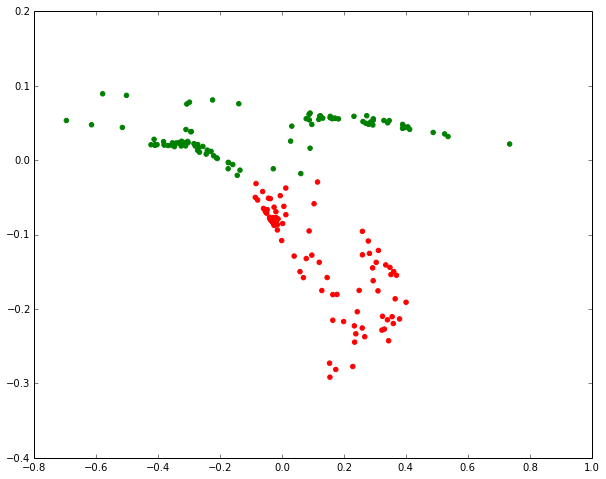

In [13]:
#Taylor decomposition explanation result
color = ['red' if l == 0 else 'green' for l in y_rel1]

plt.scatter(X_rel1[:,0], X_rel1[:,1],  color=color)

In [14]:
maps_x = []
maps_y = []
for i in range(200):
    output, model_rel = predict(model, X[i,:])
    y_rel = np.round(np.argmax(output, axis=1))
#     temp = np.asarray(np.max(output, axis=1)).reshape((1,1))
    temp = np.asarray([1.]).reshape((1,1))
    x = np.expand_dims(X[i,:], axis=0)
    temp = backward_simpleLRP_rel(temp,model_rel['a1'], model_rel['W2'], model_rel['z2'], epsilon=1e-4)
    temp = backward_simpleLRP_rel(temp,x, model_rel['W1'], model_rel['z1'], epsilon=1e-4)
    maps_x.append(temp)
    maps_y.append(y_rel)

In [15]:
X_rel = np.squeeze(maps_x, axis=1)
y_rel = np.squeeze(maps_y, axis=1)

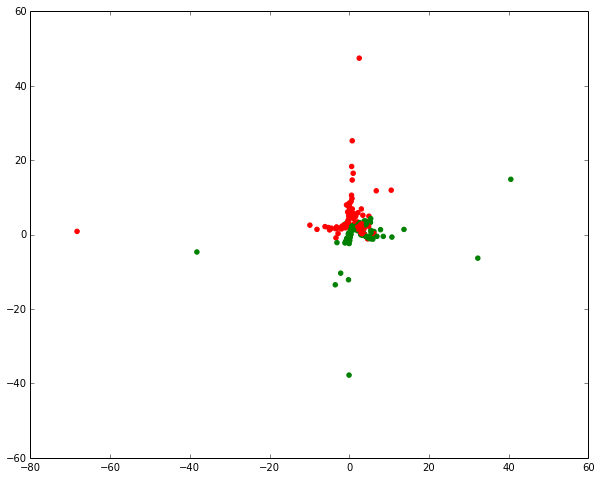

In [16]:
#Simple LRP explanation result

color1 = ['red' if l == 0 else 'green' for l in y_rel]

plt.scatter(X_rel[:,0], X_rel[:,1], color=color1)

Reference:
<a href='rrr'>https://github.com/dennybritz/nn-from-scratch/blob/master/nn-from-scratch.ipynb</a>